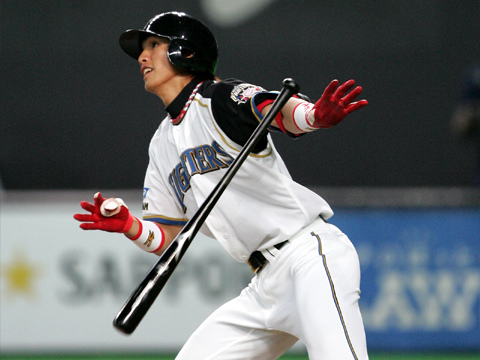

What question would you like to ask?
Why is the bat in the air?
image_embedding:  torch.Size([1, 100, 1])
batting


In [4]:
import argparse
import os
import random
import torch
import yaml
from torch.utils.data import DataLoader
from train_model.dataset_utils import prepare_test_data_set, prepare_train_data_set
import numpy as np
from os import listdir
from dataset_utils import text_processing
from train_model.helper import run_model, build_model
from IPython.display import Image, display, clear_output

config_file = './results/default/1234/config_base.yaml'
model_file = './results/default/1234/best_model.pth'
im_dir = '/u/ziming/AttnGAN/data/coco/train2014'

def get_image():
    im_files = [f for f in os.listdir(im_dir)]
    im_file = random.choice(im_files)
    im_path = os.path.join(im_dir, im_file)
    print(im_path)
    clear_output()
    display(Image(filename=im_path))
    return im_file

def get_imdb(question_str):
    imdb = []
    imdb.append({'dataset_name': 'vqa', 'version': 1, 'has_answer': False, 'has_gt_layout': False})
    iminfo = {}
    iminfo['image_name'] = im_file.replace('.jpg', '')
    iminfo['img_id'] = int(iminfo['image_name'].split('_')[-1])
    iminfo['question_id'] = 0
    iminfo['feature_path'] = iminfo['image_name'] + '.npy'
    iminfo['question_str'] = question_str
    iminfo['question_tokens'] = text_processing.tokenize(iminfo['question_str'])
    imdb.append(iminfo)
    return imdb

def print_result(question_ids, soft_max_result, ans_dic):
    predicted_answers = np.argmax(soft_max_result, axis=1)
    for idx, pred_idx in enumerate(predicted_answers):
        question_id = question_ids[idx]
        pred_ans = ans_dic.idx2word(pred_idx)
        print(pred_ans)

with open(config_file, 'r') as f:
    config = yaml.load(f)
    data_set_train = prepare_train_data_set(**config['data'], **config['model'], verbose=True, test_mode=True)

    myModel = build_model(config, data_set_train)
    myModel.load_state_dict(torch.load(model_file)['state_dict'])
    myModel.eval()
    
    im_file = get_image()
    while(True):
        print("What question would you like to ask?")
        question_str = input()
#         if question_str.lower() == 'next':
#             im_file = get_image()
#             continue
#         if question_str.lower() == 'stop':
#             print('Bye')
#             break
        data_set_train.datasets[0].imdb = get_imdb(question_str)
        data_reader_test = DataLoader(data_set_train, shuffle=False, batch_size=1)
        ans_dic = data_set_train.answer_dict

        question_ids, soft_max_result = run_model(myModel, data_reader_test, ans_dic.UNK_idx)
        print_result(question_ids, soft_max_result, ans_dic)
        break

In [2]:
myModel

DataParallel(
  (module): vqa_multi_modal_model(
    (image_embedding_models_list): ModuleList(
      (0): ModuleList(
        (0): image_embedding(
          (image_attention_model): top_down_attention(
            (modal_combine): non_linear_elmt_multiply(
              (Fa_image): nonlinear_layer(
                (main): Sequential(
                  (0): Linear(in_features=2048, out_features=5000, bias=True)
                  (1): ReLU()
                )
              )
              (Fa_txt): nonlinear_layer(
                (main): Sequential(
                  (0): Linear(in_features=1024, out_features=5000, bias=True)
                  (1): ReLU()
                )
              )
              (dropout): Dropout(p=0)
            )
            (transform): LinearTransform(
              (lc): Linear(in_features=5000, out_features=1, bias=True)
            )
          )
        )
      )
    )
    (question_embedding_models): ModuleList(
      (0): QuestionEmbeding(
        (em

In [3]:
data_set_train.answer_dict.UNK_idx

0